## Demographics

a. Identify IDs with 3T and 7T  
b. Extract clinical information for epilepsy patients  
c. Extract demographic information for all participants  


Note participant grouping:
- CTRL : no known epilepsy (identified by ID code: 3T: HC; 7T: PNC, Pilot)

- (m)TLE : temporal lobe epilepsy
    - TLE_L : TLE left lateralized
    - TLE_R : TLE right lateralized
    - TLE_U : TLE with unknown lateralization
    - mTLE_L : mTLE left lateralized
    - mTLE_R : mTLE right lateralized
- FLE : focal epilepsy that is not in temporal lobe
    - FLE_L
    - FLE_R
- UKN : Focal epilepsy with focus in unknown lobe
    - UKN_L : Unknown lobe with known L lateralization
    - UKN_R : Unknown lobe with known R lateralization
    - UKN_U : Unknown lobe with unknown lateralization
- MFCL : multifocal epilepsy
    - MFCL : multifocal epilepsy
    - MFCL_TLE_L : bilateral TLE (L>R)
    - MFCL_TLE_R : bilateral TLE (R>L)


In [1]:
import pandas as pd
import os
import sys
import importlib

sys.path.append("/Users/danielmendelson/Library/CloudStorage/OneDrive-McGillUniversity/Documents/PhD/Boris/code")
#sys.path.append("/host/verges/tank/data/daniel/")
from Utils import id, gen, t1

# I. Functions

In [56]:
def group(df, ID_col="MICS_ID", out_col="grp", save_pth=None, MFCL_col="Epilepsy classification:Focal,Generalized", lobe_col="Epileptogenic focus confirmed by the information of (sEEG/ site of surgical resection/ Ictal EEG abnormalities +/. MRI findings): FLE=forntal lobe epilepsy and cingulate epilepsy, CLE:central/midline epilepsy,ILE: insular epilepsy, mTLE=mesio.temporal lobe epilepsy, nTLE=neocortical lobe epilepsy, PQLE=posterior quadrant lobe epilepsy , multifocal epilepsy,IGE=ideopathic lobe epilepsy,unclear)", lat_col="Lateralization of epileptogenic focus"):
    """
    Requires pandas as pd

    Inputs:
    df: str or pd.DataFrame
        demographics data
    ID_col: str
        Column name for the ID
    out_col: str
        Column name for the output group classification. 
        Options: 'grp' returns high-level grouping. All other col_names return detailed grouping.
    MFCL_col: str
        Column name for the multifocal classification
    lobe_col: str  
        Column name for the lobe classification
    lat_col: str
        Column name for the lateralization classification

    Outputs:
    df: pd.DataFrame
        DataFrame with the group classification added
    """

    import pandas as pd
    import os

    print("[group] Identifying participant groups")
    # check if df is a string (path) or dataframe
    if isinstance(df, str):
        # check if file exists
        if not os.path.isfile(df):
            raise ValueError(f"[group] Error: {df} does not exist.")
        
        # read in file
        df = pd.read_csv(df, dtype=str)
    elif isinstance(df, pd.DataFrame):
        pass
    else:
        raise ValueError("[group] Error: df must be a string (path) or dataframe")

    df[out_col] = ''

    if ID_col == "MICS_ID":
        ctrl_ptrn = ["HC"]
    elif ID_col == "PNI_ID":
        ctrl_ptrn = ["Pilot", "PNC"]
    else:
        raise ValueError("[group] Error: ID_col must be 'MICS_ID' or 'PNI_ID'")

    
    if out_col == "grp":
        print("\tReturning highlevel grouping to column: ", out_col)
       
        df.loc[df[ID_col].astype(str).str.contains('|'.join(ctrl_ptrn), na=False), out_col] = 'CTRL'
        
        # TLE: L, R, right, unclear
        df.loc[
            (df[lobe_col].astype(str).str.lower() == 'tle') & 
            (df[lat_col].astype(str).str.lower().str.contains('l|r|right|unclear', na=False)), 
            out_col
        ] = 'TLE'
        
        # mTLE: L, R, right, unclear
        df.loc[
            (df[lobe_col] == 'mTLE') & 
            (df[lat_col].astype(str).str.contains('l|r|right|unclear', case=False, na=False)), 
            out_col
        ] = 'TLE'
        
        # FLE: L, R, right, unclear
        df.loc[
            (df[lobe_col] == 'FLE') & 
            (df[lat_col].astype(str).str.contains('l|r|right|unclear', case=False, na=False)), 
            out_col
        ] = 'FLE'
        
        # Unclear: L, R, right, unclear
        df.loc[(df[lobe_col].astype(str).str.contains('unclear', na=False)) & (df[lat_col] == 'L'), out_col] = 'UKN'
        df.loc[(df[lobe_col].astype(str).str.contains('unclear', na=False)) & ((df[lat_col] == 'R') | (df[lat_col].astype(str).str.lower() == 'right')), out_col] = 'UKN'
        df.loc[(df[lobe_col].astype(str).str.contains('unclear', na=False)) & (df[lat_col].astype(str).str.contains('unclear', na=False)), out_col] = 'UKN'
        
        # Multifocal
        df.loc[(df[MFCL_col] == 'Multifocal'), out_col] = 'MFCL'
        df.loc[
            (df[lobe_col] == 'TLE') & 
            (df[lat_col].astype(str).str.contains('l>r|r>l|bl')),
            out_col
        ] = 'MFCL'
    
    else:  
        print("\tReturning detailed grouping to column: ", out_col) 
        
        df.loc[df[ID_col].astype(str).str.contains('|'.join(ctrl_ptrn), na=False), out_col] = 'CTRL'
        
        df.loc[(df[lobe_col] == 'TLE') & (df[lat_col] == 'L'), out_col] = 'TLE_L'
        df.loc[(df[lobe_col] == 'TLE') & ((df[lat_col] == 'R') | (df[lat_col].astype(str).str.lower() == 'right')), out_col] = 'TLE_R'
        df.loc[(df[lobe_col] == 'TLE') & (df[lat_col].astype(str).str.contains('unclear', na=False)), out_col] = 'TLE_U'
        df.loc[(df[lobe_col] == 'mTLE') & (df[lat_col] == 'L'), out_col] = 'mTLE_L'
        df.loc[(df[lobe_col] == 'mTLE') & ((df[lat_col] == 'R') | (df[lat_col].astype(str).str.lower() == 'right')), out_col] = 'mTLE_R'

        df.loc[(df[lobe_col] == 'FLE') & (df[lat_col] == 'L'), out_col] = 'FLE_L'
        df.loc[(df[lobe_col] == 'FLE') & ((df[lat_col] == 'R') | (df[lat_col].astype(str).str.lower() == 'right')), out_col] = 'FLE_R'

        df.loc[(df[lobe_col].astype(str).str.contains('unclear', na=False)) & (df[lat_col] == 'L'), out_col] = 'UKN_L'
        df.loc[(df[lobe_col].astype(str).str.contains('unclear', na=False)) & ((df[lat_col] == 'R') | (df[lat_col].astype(str).str.lower() == 'right')), out_col] = 'UKN_R'
        df.loc[(df[lobe_col].astype(str).str.contains('unclear', na=False)) & (df[lat_col].astype(str).str.contains('unclear', na=False)), out_col] = 'UKN_U'
        
        df.loc[(df[MFCL_col] == 'Multifocal'), out_col] = 'MFCL'
        df.loc[(df[lobe_col] == 'TLE') & (df[lat_col] == 'L>R'), out_col] = 'MFCL_bTLE_L'
        df.loc[(df[lobe_col] == 'TLE') & (df[lat_col] == 'R>L'), out_col] = 'MFCL_bTLE_R'
        df.loc[(df[lobe_col] == 'TLE') & (df[lat_col] == 'BL'), out_col] = 'MFCL_bTLE'
    
    return df

In [3]:
def main(sheets, save_pth=None, save_name="demo"):
    """
    Run all functions to generate demographic data for 3T-7T participants.

    input:
        sheets: list of dictionarys with source sheet information (path to sheet, key columns to extract
        save_pth: path to save the output demographic file
    
      """
    
    import os
    sys.path.append("/Users/danielmendelson/Library/CloudStorage/OneDrive-McGillUniversity/Documents/PhD/Boris/code") # on mac
    #sys.path.append("/host/verges/tank/data/daniel/") # on lab computer
    from Utils import id, t1

    import importlib
    importlib.reload(id)
    importlib.reload(t1)
    
    out = id.ids3T7T(sheets, save_pth=None) # determine participants with 3T and 7T data
    out = id.id_visits(sheets, out, save_pth=None) # get all sessions for these participants
    
    out = t1.demo(sheets, out, save_pth=None) # add demographic info
    out = t1.dateDif(out, ["DOB_ddmmyyyy", "Date"], "age", save=False) # compute age

    out = group(out, out_col="grp", ID_col="MICS_ID", save_pth=None) # assign high level groups
    out = group(out, out_col="grp_detailed", ID_col="MICS_ID", save_pth=None) # assign detailed groups
    
    if save_pth is not None:
        import datetime

        save_name = f"{save_pth}/{save_name}_{datetime.datetime.now().strftime('%d%b%Y')}.csv"
        out.to_csv(save_name, index=False)
        print("[main] Saved to: ", save_name)
    else:
        print("[main] WARNING. Not saving demographics sheet to file. To save, please provide a path to save_pth")
        
    return out

## II. Make participant demographics sheet

In [4]:
src_dir = "/Users/danielmendelson/Library/CloudStorage/OneDrive-McGillUniversity/Documents/PhD/Boris/projects/PT/sources" # path to directory with source pt sheets

# For each sheet, must define NAME, PATH, SHEET, ID_7T, ID_3T. 
# All other keys are those to be extracted.
# The same variables should have the same key names across sheets.

PNI = {
    'NAME': 'PNI',
    'PATH': f'{src_dir}/MICA_PNI_19May2025.xlsx', # 7T controls
    'SHEET': 'all', # name of sheet in file
    'ID_7T': 'ID_PNI', 
    'ID_3T': 'ID_MICs',
    'Ses_7T': 'session',
    'Date_7T': 'scanDate',
    'study': '7T',
    'Sex': 'sex',
    'Gender': 'gender',
    'Hand': 'handedness',
    'Eth': 'ethnicity',
    'Job': 'employment',
    'Edu': 'education',
    'LastSz': 'lastSeizure'
}

MICs = {
    'NAME': 'MICs',
    'PATH': f'{src_dir}/MICA-MTL-3T_19May2025.xlsx', # 3T controls
    'SHEET': 'Sheet1', # name of sheet in file
    'ID_7T': None, 
    'ID_3T': 'Study_name',
    'Ses_3T': 'Visit',
    'Date_3T': 'Scan_Date (D.M.Y)',
    'study': '3T',
    'Hand': 'Handed', 
    'Sex': 'AssignedSex',
    'Gender': 'Gender',
    'Height': 'HeightApprox',
    'Weight': 'WeightApprox',
    'Eth': 'Ethnicity',
    'Glasses': 'Glasses',
    'Job': 'Employ',
    'Edu': 'YoE',
    'LastSz': 'Last seizure'
}

Clin = {
    'NAME': 'Clin',
    'PATH': f'{src_dir}/Clinical_19May2025.xlsx',
    'SHEET': 'Sheet1', # name of sheet in file
    'ID_7T': None, 
    'ID_3T': 'participant_id',
    'scanDate_3t': 'scan_date',
    'Gender': 'Gender',
    'Hand': 'Handedness',
    'Language': 'Language',
    'Job': 'Employment',
    'Edu': 'Education',
    'EpilepsyDxILAE': 'Epilepsy diagnosis based on ILAE',
    'EpilepsyClass': 'Epilepsy classification:Focal,Generalized',
    'FocusLat': 'Lateralization of epileptogenic focus',
    'FocusConfirmed': 'Epileptogenic focus confirmed by the information of (sEEG/ site of surgical resection/ Ictal EEG abnormalities +/. MRI findings): FLE=forntal lobe epilepsy and cingulate epilepsy, CLE:central/midline epilepsy,ILE: insular epilepsy, mTLE=mesio.temporal lobe epilepsy, nTLE=neocortical lobe epilepsy, PQLE=posterior quadrant lobe epilepsy , multifocal epilepsy,IGE=ideopathic lobe epilepsy,unclear)',
    'EMUDischargeDx': 'Dx at EMU discharge ',
    'EMUAdmissionDate': 'EMU admission date(dd-mm-yy)',
    'AdmissionDuration': 'Duration of admission',
    'EpilepsyRiskFactors': 'Risk factors for epilepsy',
    'SeizureOnsetYr': 'Seizure onset (yr)',
    'DrugResistant': 'Drug resistant epilepsy at time of EMU admission',
    'NumASMsPrior': '# of ASMs prior current EMU admission',
    'PrevASMs': 'Previous ASMs (name and doses (mg/d)) if applicable prior the current EMU admission',
    'NumASMOnAdmission': '# of ASM on admission',
    'ASMsOnAdmission': 'ASMs  on admission (name, doses (mg per day)',
    'GeneticTest': 'Genetic test (year,results)',
    'FDGPET': 'FDG.PET',
    'BaselineMRI': 'Baseline MRI (year,results)',
    'InvasiveExplorations': 'Invasive explorations (Y/N)',
    'NumSurgicalResections': '# of surgical resection/thermocoagulatin',
    'SurgicalResectionDateSite': 'Surgical resection date and site',
    'Histopathology': 'Histopatholgy',
    'Engel6mo': 'Engel classification (seizure outcomes at the 6 month )',
    'Engel1yr': 'Engel classification (seizure outcomes after 1 year from surgical resection)',
    'ILAEOutcome1yr': 'ILAE outcome after surgical resection by 1 yr',
    'NeuromodDevices': 'Neuromodulation devices'
    }

DOB_PNI = {
        'NAME': 'DOB_7T',
        'PATH': f'{src_dir}/PNI_DOB_12May.xlsx',
        'SHEET': 'Sheet1', # name of sheet in file
        'ID_7T': 'PNI', 
        'ID_3T': 'MICS',
        'DOB_colName': 'DOB_ddmmyyyy'
        }

sheets = [PNI, MICs, DOB_PNI, Clin]
correspSheets = [PNI]

In [57]:
save_pth = "/Users/danielmendelson/Library/CloudStorage/OneDrive-McGillUniversity/Documents/PhD/Boris/projects/3T7T/data"
demo = main(sheets, save_pth=save_pth)

[ID_3T7T] Extracting IDs for participants with both 3T and 7T IDs
	Loading: PNI
	Skipping: MICs (missing ID_7T or ID_3T key)
	Loading: DOB_7T
	Skipping: Clin (missing ID_7T or ID_3T key)
[id_visits] Extracting visits for IDs in list
	Skipping: DOB_7T (missing Ses_7T or Ses_3T key)
	Skipping: Clin (missing Ses_7T or Ses_3T key)


	PNI
		Extracting cols: ['ID_MICs', 'ID_PNI', 'scanDate', 'session']
	MICs
		Extracting cols: ['Study_name', 'Scan_Date (D.M.Y)', 'Visit']
		Finding corresponding ID_7T
[demo] Retrieving demographics data.
	Overlapping: ['Sex', 'Gender', 'Hand', 'Eth', 'Job', 'Edu', 'LastSz']
	PNI
		merge_keys: ['ID_7T', 'ID_3T', 'Ses_7T']
	MICs
		merge_keys: ['ID_3T', 'Ses_3T']
	DOB_7T
		merge_keys: ['ID_7T', 'ID_3T']
	Clin
		merge_keys: ['ID_3T']
	Removing empty columns: ['Ethnicity', 'Scan_Date (D.M.Y)', 'WeightApprox', 'Glasses', 'Employ', 'Handed', 'YoE', 'HeightApprox', 'AssignedSex', 'Engel classification (seizure outcomes at the 6 month )', '# of surgical resection/ther

!! ENSURE THAT GROUPING OCCURED PROPERLY !!

In [58]:
demo[["MICS_ID", "PNI_ID", "SES", "grp", "grp_detailed"]]

,MICS_ID,PNI_ID,SES,grp,grp_detailed
0,HC129,Pilot013,05,CTRL,CTRL
1,HC082,PNC003,01,CTRL,CTRL
2,HC082,PNC003,02,CTRL,CTRL
3,HC082,PNC003,03,CTRL,CTRL
4,HC082,PNC003,04,CTRL,CTRL
...,...,...,...,...,...
116,HC130,PNC026,02,CTRL,CTRL
117,HC083,PNC011,02,CTRL,CTRL
118,PX215,PNE020,01,UKN,UKN_U
119,PX216,PNE021,01,TLE,TLE_R


In [61]:
# print all cases with missing group
missing = demo[(demo["grp"] == "") | (demo["grp_detailed"] == "")]
if len(missing) > 0:
    missing[
    ["MICS_ID", "PNI_ID", "SES", "grp", "grp_detailed", 
        "Epileptogenic focus confirmed by the information of (sEEG/ site of surgical resection/ Ictal EEG abnormalities +/. MRI findings): FLE=forntal lobe epilepsy and cingulate epilepsy, CLE:central/midline epilepsy,ILE: insular epilepsy, mTLE=mesio.temporal lobe epilepsy, nTLE=neocortical lobe epilepsy, PQLE=posterior quadrant lobe epilepsy , multifocal epilepsy,IGE=ideopathic lobe epilepsy,unclear)", 
        "Lateralization of epileptogenic focus"]
        ]
else:
    print("All assigned a group")

All assigned a group



# Get summary statistics by category

In [62]:
# print number per group, median age, number of 3T and 7T sessions in each group
#demo['grp'].value_counts()
# count unique participants per group
demo.groupby('grp')['MICS_ID'].nunique()

grp
CTRL    12
FLE      3
MFCL     1
TLE     13
UKN      4
Name: MICS_ID, dtype: int64

In [69]:
demo[['grp', 'study', 'SES']].drop_duplicates().sort_values(['grp', 'study', 'SES'])


,grp,study,SES
74,CTRL,3T,01
75,CTRL,3T,02
83,CTRL,3T,03
120,CTRL,3T,04
1,CTRL,7T,01
2,CTRL,7T,02
3,CTRL,7T,03
4,CTRL,7T,04
0,CTRL,7T,05
17,CTRL,7T,a1


In [ ]:
# get median age per study in each group
demo.groupby(['grp', 'study'])['age'].median().sort_index(level='grp')

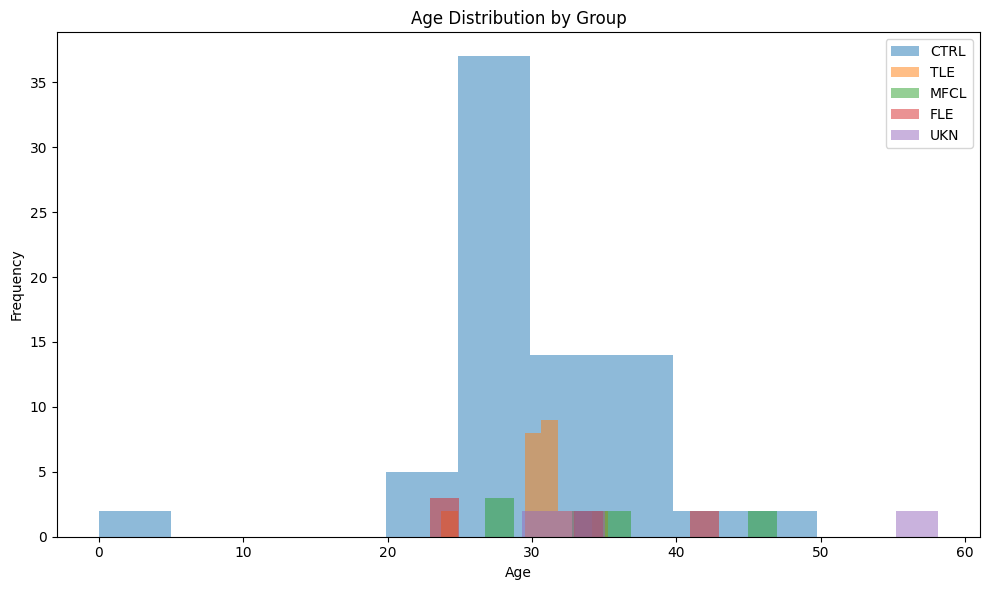

In [ ]:
# show histograms for each group

def plot_histogram(data, group_col, age_col, title):
    """
    Overlay histograms of age distribution for each group in the DataFrame.

    Parameters:
    data (pd.DataFrame): DataFrame containing the data.
    group_col (str): Column name for the group classification.
    age_col (str): Column name for the age values.
    title (str): Title for the plot.
    """
    import matplotlib.pyplot as plt
    import pandas as pd

    plt.figure(figsize=(10, 6))

    # Convert age column to numeric, coerce errors to NaN
    ages = pd.to_numeric(data[age_col], errors='coerce')

    # Overlay histograms for each group
    groups = data[group_col].unique()
    for grp in groups:
        subset = data[data[group_col] == grp]
        age_vals = pd.to_numeric(subset[age_col], errors='coerce').dropna()
        plt.hist(age_vals, bins=10, alpha=0.5, label=grp)

    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_histogram(demo, 'grp_highLvl', 'age', 'Age Distribution by Group')
